In [1]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import k_means
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score, silhouette_score
import itertools

In [2]:
# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health = pd.read_csv('health_data_preprocessed.csv')

df_health.drop('DRK_YN', axis=1,inplace=True)
df_health.dropna(inplace=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


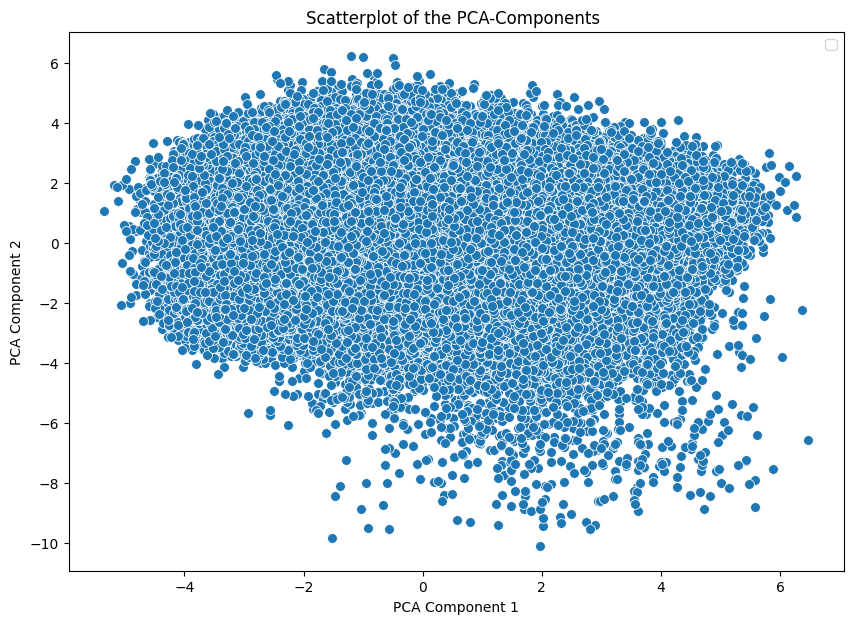

In [7]:
# Apply PCA to reduce the data to two components for two dimensional plotting.
pca = PCA(n_components=2, random_state=42) 
X_pca = pca.fit_transform(df_health)

# Visualize the data
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], marker='o', s=50)
plt.title('Scatterplot of the PCA-Components ')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

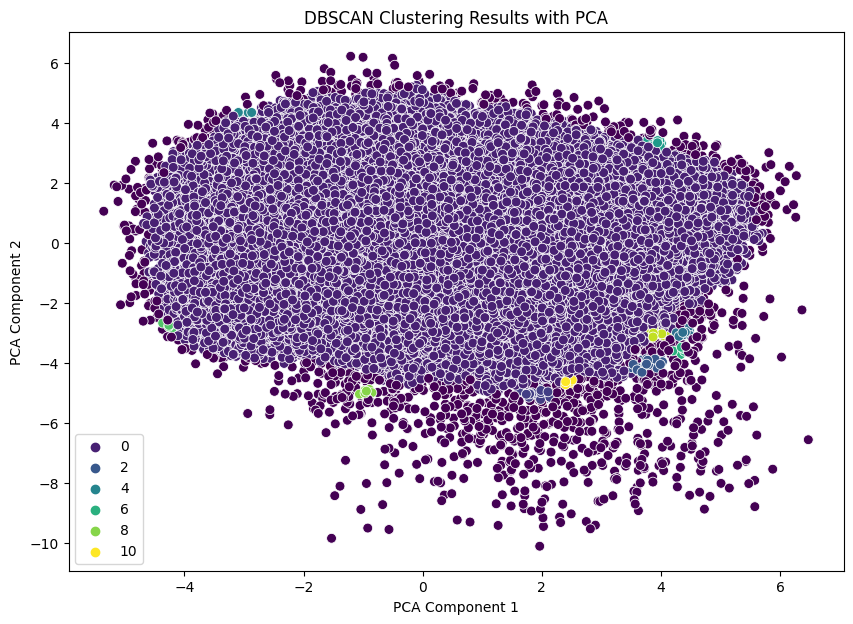

In [12]:
# Create and train the DBSCAN model
dbscan = DBSCAN(eps=0.15, min_samples=10)
labels = dbscan.fit_predict(X_pca)

# Visualize the results
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=labels, palette='viridis', marker='o', s=50)
plt.title('DBSCAN Clustering Results with PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend()
plt.show()

In [14]:
silhouette_avg = silhouette_score(X_pca, labels)
print("Silhouette Score:", silhouette_avg)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X_pca, labels)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X_pca, labels)
print(f'Calinski-Harabasz Score: {ch_score:.4f}')

# Inertia (within-cluster sum of squares)
inertia = k_means.inertia_
print(f'Inertia: {inertia:.4f}')

KeyboardInterrupt: 

In [6]:
# Grab a subset of the data
df_health = pd.read_csv('health_data_preprocessed.csv')

df_health.drop('DRK_YN', axis=1,inplace=True)
df_health.dropna(inplace=True)

df_health=df_health.sample(50000, random_state=42)

# Apply PCA to reduce the data to two components for two dimensional plotting.
pca = PCA(n_components=2, random_state=42) 
X_pca = pca.fit_transform(df_health)
X_pca = X_pca

# GridSearch Setup
epsilons = np.linspace(0.05, 0.75, num=10)
print(epsilons)

min_samples = np.arange(2, 20, step=3)
print(min_samples)

combinations = list(itertools.product(epsilons, min_samples))
N = len(combinations)
print(N)
len(X_pca)

[0.05       0.12777778 0.20555556 0.28333333 0.36111111 0.43888889
 0.51666667 0.59444444 0.67222222 0.75      ]
[ 2  5  8 11 14 17]
60


50000

In [2]:
# Function for gridsearching the DBSCAN hyperparameters epsilon and minimum number of samples

def gridsearch_dbscan(combinations, X):
  scores = []
  all_labels_list = []

  for i, (eps, num_samples) in enumerate(combinations):
    dbscan_cluster_model = DBSCAN(eps=eps, min_samples=num_samples).fit(X)
    labels = dbscan_cluster_model.labels_
    labels_set = set(labels)
    num_clusters = len(labels_set)
    if -1 in labels_set:
      num_clusters -= 1
    
    if (num_clusters < 2) or (num_clusters > 50):
      scores.append(-10)
      all_labels_list.append('bad')
      c = (eps, num_samples)
      print(f"Combination {c} on iteration {i+1} of {N} has {num_clusters} clusters. Moving on")
      continue
    
    scores.append(silhouette_score(X, labels))
    all_labels_list.append(labels)
    print(f"Index: {i}, Score: {scores[-1]}, Labels: {all_labels_list[-1]}, NumClusters: {num_clusters}")

  best_index = np.argmax(scores)
  best_parameters = combinations[best_index]
  best_labels = all_labels_list[best_index]
  best_score = scores[best_index]

  return {'best_epsilon': best_parameters[0],
          'best_min_samples': best_parameters[1], 
          'best_labels': best_labels,
          'best_score': best_score}

#best_dict = gridsearch_dbscan(combinations, X_pca)

In [12]:
best_dict

{'best_epsilon': 0.6722222222222223,
 'best_min_samples': 2,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'best_score': 0.48988212572326695}

In [ ]:
# Use the best parameters to perform clustering on the full data 

# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health_full = pd.read_csv('health_data_preprocessed.csv')

df_health_full.drop('DRK_YN', axis=1,inplace=True)
df_health_full.dropna(inplace=True)

df_health_largest_sample = df_health_full.sample(250000,random_state=42)

# Apply PCA to reduce the data to two components for two dimensional plotting.
pca_largest_sample = PCA(n_components=2, random_state=42) 
pca_largest_sample = pca.fit_transform(df_health_largest_sample)
print(len(pca_largest_sample))

dbscan_w_optimal_parameters = DBSCAN(eps=best_dict['best_epsilon'], min_samples=best_dict['best_min_samples']).fit(pca_largest_sample)

df_health_largest_sample['cluster'] = dbscan_w_optimal_parameters.labels_

250000


In [20]:
df_health_largest_sample.to_csv('df_health_largest_sample.csv', index=False) 

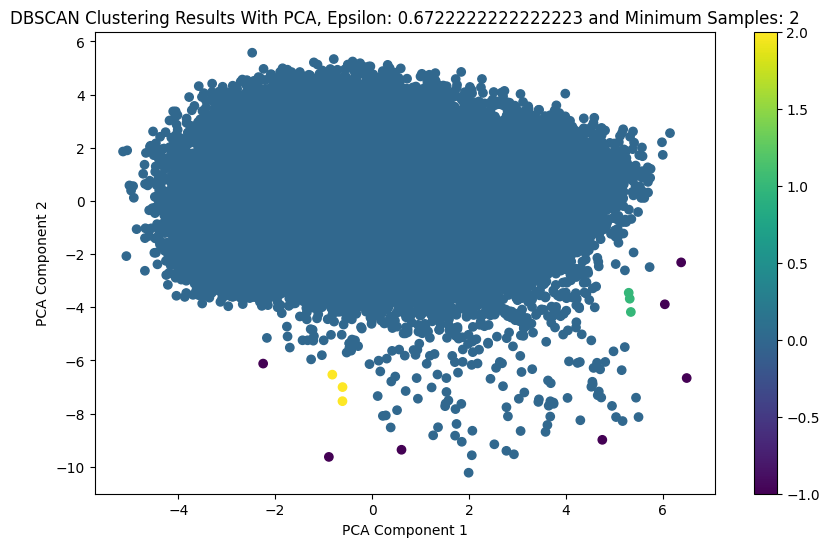

In [26]:
# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(pca_largest_sample[:, 0], pca_largest_sample[:, 1], c=dbscan_w_optimal_parameters.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'DBSCAN Clustering Results With PCA, Epsilon: {best_dict["best_epsilon"]} and Minimum Samples: {best_dict["best_min_samples"]}')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()

In [27]:
labels = dbscan_w_optimal_parameters.labels_

silhouette_avg = silhouette_score(pca_largest_sample, labels)
print("Silhouette Score:", silhouette_avg)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(pca_largest_sample, labels)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(pca_largest_sample, labels)
print(f'Calinski-Harabasz Score: {ch_score:.4f}')

# Inertia (within-cluster sum of squares)
inertia = k_means.inertia_
print(f'Inertia: {inertia:.4f}')

Silhouette Score: 0.5136657198340497
Davies-Bouldin Index: 1.1396
Calinski-Harabasz Score: 43.1511


AttributeError: 'function' object has no attribute 'inertia_'

In [3]:
##### Trying to cluster based on Gamma GTP and Total Cholesterol
# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health_liver = pd.read_csv('health_data_preprocessed.csv')

df_health_liver.drop('DRK_YN', axis=1,inplace=True)
df_health_liver.dropna(inplace=True)

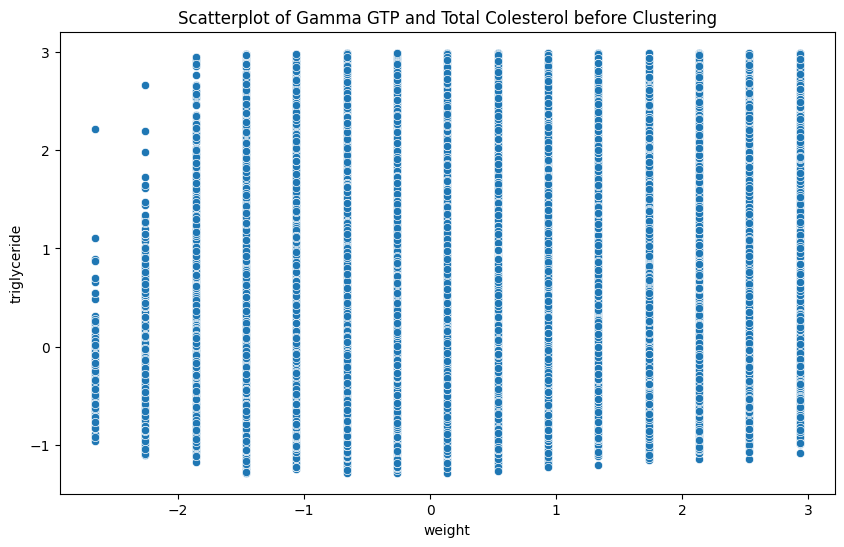

In [ ]:
# Select relevant features for clustering
features = ['weight', 'tot_chole']
X = df_health_liver[features]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weight', y='hemoglobin', data=X)
plt.title('Scatterplot of Gamma GTP and Total Colesterol before Clustering')
plt.xlabel('triglyceride')
plt.ylabel('hemoglobin')
plt.show()


In [7]:
X = X.sample(50000,random_state=42)
best_dict = gridsearch_dbscan(combinations, X)

Combination (0.05, 2) on iteration 1 of 60 has 612 clusters. Moving on
Combination (0.05, 5) on iteration 2 of 60 has 289 clusters. Moving on
Combination (0.05, 8) on iteration 3 of 60 has 191 clusters. Moving on
Combination (0.05, 11) on iteration 4 of 60 has 142 clusters. Moving on
Combination (0.05, 14) on iteration 5 of 60 has 124 clusters. Moving on
Combination (0.05, 17) on iteration 6 of 60 has 107 clusters. Moving on
Index: 6, Score: 0.27599228640388157, Labels: [0 0 0 ... 0 0 0], NumClusters: 18
Index: 7, Score: 0.2950536306152555, Labels: [0 0 0 ... 0 0 0], NumClusters: 9
Index: 8, Score: 0.4696514260800752, Labels: [0 0 0 ... 0 0 0], NumClusters: 2
Index: 9, Score: 0.48818472856951384, Labels: [0 0 0 ... 0 0 0], NumClusters: 2
Combination (0.12777777777777777, 14) on iteration 11 of 60 has 1 clusters. Moving on
Index: 11, Score: 0.36387253183523194, Labels: [0 0 0 ... 0 0 0], NumClusters: 3
Index: 12, Score: 0.4540225713524743, Labels: [0 0 0 ... 0 0 0], NumClusters: 4
Combi

In [8]:
best_dict

{'best_epsilon': 0.2833333333333333,
 'best_min_samples': 2,
 'best_labels': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'best_score': 0.5914750988691955}

In [ ]:
# Use the best parameters to perform clustering on the full data 
# Select relevant features for clustering
features = ['triglyceride', 'hemoglobin']

# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health_full = pd.read_csv('health_data_preprocessed.csv')

df_health_full.drop('DRK_YN', axis=1,inplace=True)
df_health_full.dropna(inplace=True)

X = df_health_full.sample(100000,random_state=42)
X = X[features]

dbscan_w_optimal_parameters = DBSCAN(eps=best_dict['best_epsilon'], min_samples=best_dict['best_min_samples']).fit(X)

X['cluster'] = dbscan_w_optimal_parameters.labels_

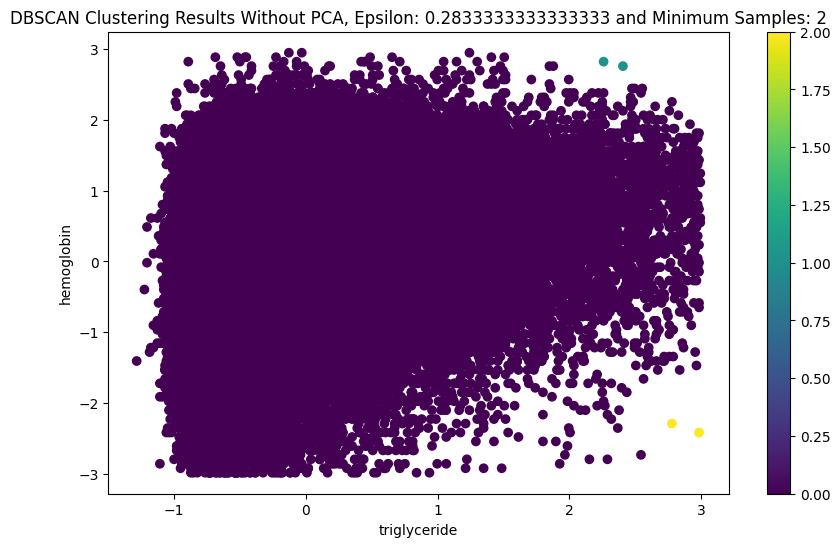

In [13]:
# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X['triglyceride'], X['hemoglobin'], c=dbscan_w_optimal_parameters.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'DBSCAN Clustering Results Without PCA, Epsilon: {best_dict["best_epsilon"]} and Minimum Samples: {best_dict["best_min_samples"]}')
plt.xlabel('triglyceride')
plt.ylabel('hemoglobin')
plt.show()

In [15]:
labels = dbscan_w_optimal_parameters.labels_

silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Score: {ch_score:.4f}')

Silhouette Score: 0.5865340401690518
Davies-Bouldin Index: 0.2771
Calinski-Harabasz Score: 24.7878


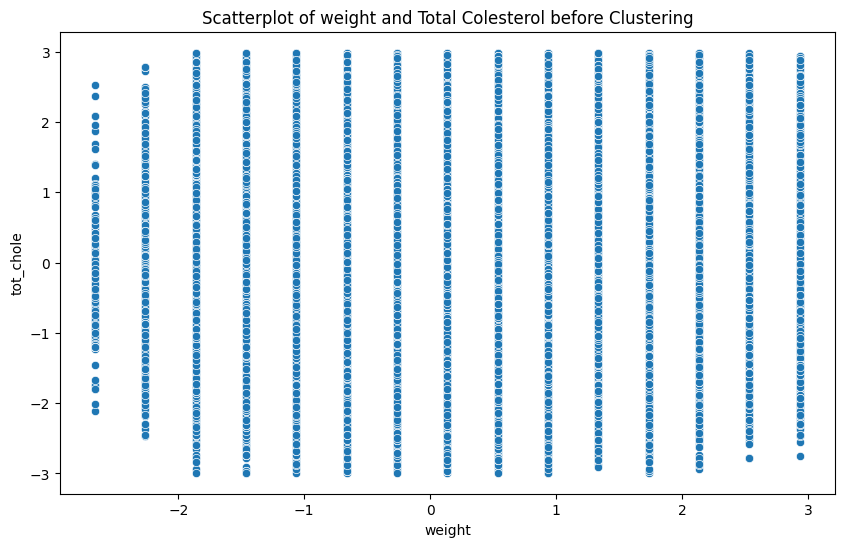

In [19]:
# Select relevant features for clustering
features = ['weight', 'tot_chole']
X = df_health_liver[features]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='weight', y='tot_chole', data=X)
plt.title('Scatterplot of weight and Total Colesterol before Clustering')
plt.xlabel('weight')
plt.ylabel('tot_chole')
plt.show()


In [20]:
X = X.sample(50000,random_state=42)
best_dict_age = gridsearch_dbscan(combinations, X)

Combination (0.05, 2) on iteration 1 of 60 has 133 clusters. Moving on
Combination (0.05, 5) on iteration 2 of 60 has 75 clusters. Moving on
Combination (0.05, 8) on iteration 3 of 60 has 66 clusters. Moving on
Combination (0.05, 11) on iteration 4 of 60 has 51 clusters. Moving on
Combination (0.05, 14) on iteration 5 of 60 has 54 clusters. Moving on
Combination (0.05, 17) on iteration 6 of 60 has 51 clusters. Moving on
Index: 6, Score: 0.0539039512953988, Labels: [0 0 1 ... 2 4 4], NumClusters: 28
Index: 7, Score: 0.0753953179828702, Labels: [0 0 1 ... 2 4 4], NumClusters: 20
Index: 8, Score: 0.056548215443071384, Labels: [0 0 1 ... 2 4 4], NumClusters: 20
Index: 9, Score: 0.09092477092030915, Labels: [0 0 1 ... 2 4 4], NumClusters: 15
Index: 10, Score: 0.09350853037684387, Labels: [0 0 1 ... 2 4 4], NumClusters: 15
Index: 11, Score: 0.09462738621168913, Labels: [0 0 1 ... 2 4 4], NumClusters: 14
Index: 12, Score: 0.08040360706816557, Labels: [0 0 1 ... 2 4 4], NumClusters: 19
Index: 

In [22]:
best_dict_age

{'best_epsilon': 0.2833333333333333,
 'best_min_samples': 2,
 'best_labels': array([0, 0, 1, ..., 2, 4, 4], dtype=int64),
 'best_score': 0.10395591342467757}

In [23]:
# Use the best parameters to perform clustering on the full data 
# Select relevant features for clustering
features = ['weight', 'tot_chole']

# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health_full = pd.read_csv('health_data_preprocessed.csv')

df_health_full.drop('DRK_YN', axis=1,inplace=True)
df_health_full.dropna(inplace=True)

X = df_health_full.sample(100000,random_state=42)
X = X[features]

dbscan_w_optimal_parameters = DBSCAN(eps=best_dict['best_epsilon'], min_samples=best_dict['best_min_samples']).fit(X)

X['cluster'] = dbscan_w_optimal_parameters.labels_

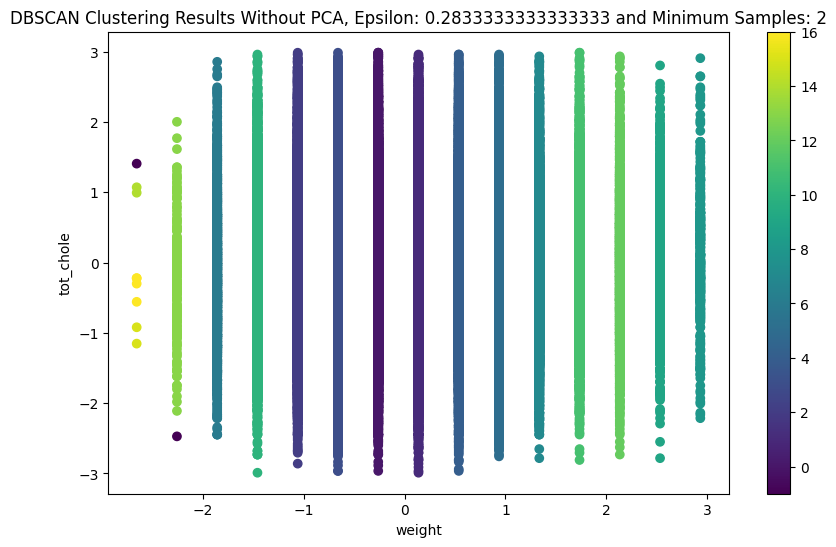

In [24]:
# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X['weight'], X['tot_chole'], c=dbscan_w_optimal_parameters.labels_, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'DBSCAN Clustering Results Without PCA, Epsilon: {best_dict_age["best_epsilon"]} and Minimum Samples: {best_dict_age["best_min_samples"]}')
plt.xlabel('weight')
plt.ylabel('tot_chole')
plt.show()

In [25]:
labels = dbscan_w_optimal_parameters.labels_

silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Score: {ch_score:.4f}')

Silhouette Score: 0.3991039421390269
Davies-Bouldin Index: 0.9989
Calinski-Harabasz Score: 77350.2254


In [ ]:
#### trying it for height and gamma gtp as determined by the tree ###

In [28]:
# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health_height_gammagtp = pd.read_csv('health_data_preprocessed.csv')

df_health_height_gammagtp.drop('DRK_YN', axis=1,inplace=True)
df_health_height_gammagtp.dropna(inplace=True)

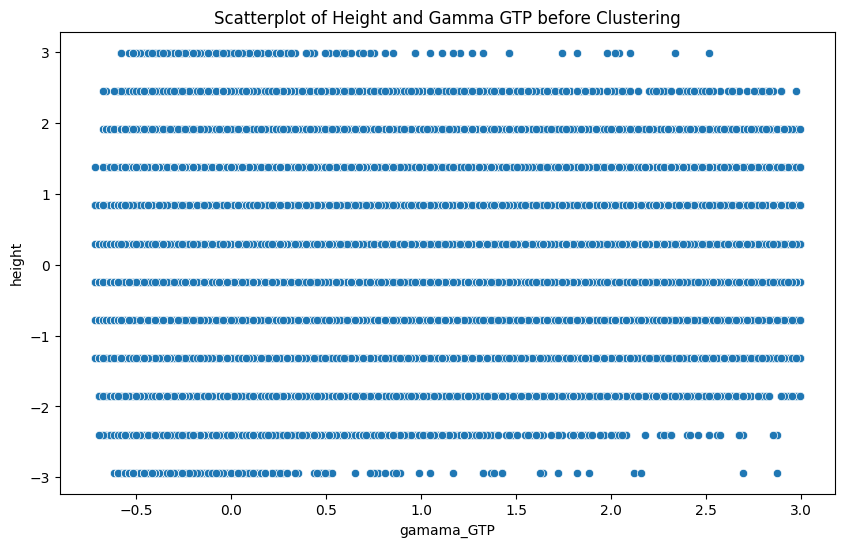

In [29]:
# Select relevant features for clustering
features = ['gamma_GTP', 'height']
X = df_health_height_gammagtp[features]

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x='gamma_GTP', y='height', data=X)
plt.title('Scatterplot of Height and Gamma GTP before Clustering')
plt.xlabel('gamama_GTP')
plt.ylabel('height')
plt.show()

In [30]:
X = X.sample(50000,random_state=42)
best_dict_height_gammgtp = gridsearch_dbscan(combinations, X)

Combination (0.05, 2) on iteration 1 of 60 has 58 clusters. Moving on
Index: 1, Score: 0.43176942978201854, Labels: [0 1 2 ... 9 0 5], NumClusters: 34
Index: 2, Score: 0.43314997250837994, Labels: [ 0  1  2 ... 10  0  6], NumClusters: 28
Index: 3, Score: 0.43683915846339655, Labels: [ 0  1 -1 ...  9  0  5], NumClusters: 23
Index: 4, Score: 0.4416950195764592, Labels: [ 0  1 -1 ... 16  0  5], NumClusters: 17
Index: 5, Score: 0.427617924514335, Labels: [ 0  1 -1 ... 18  0  5], NumClusters: 20
Index: 6, Score: 0.4351327267759851, Labels: [0 1 2 ... 4 0 5], NumClusters: 21
Index: 7, Score: 0.4403093864912571, Labels: [0 1 2 ... 4 0 5], NumClusters: 13
Index: 8, Score: 0.43824264316564326, Labels: [0 1 2 ... 4 0 5], NumClusters: 13
Index: 9, Score: 0.4290150567567002, Labels: [0 1 2 ... 4 0 5], NumClusters: 15
Index: 10, Score: 0.4329032611198947, Labels: [0 1 2 ... 4 0 5], NumClusters: 14
Index: 11, Score: 0.4398003317219455, Labels: [0 1 2 ... 4 0 5], NumClusters: 12
Index: 12, Score: 0.4

In [37]:
best_dict_height_gammgtp
print(best_dict_height_gammgtp)

# Original set
height_gammgtp_labels_set = set(best_dict_height_gammgtp['best_labels'])

# Filtered set with values greater than 0
filtered_set = {label for label in height_gammgtp_labels_set if label > -1}

height_gammgtp_num_clusters = len(filtered_set)
print(height_gammgtp_num_clusters)

{'best_epsilon': 0.2833333333333333, 'best_min_samples': 5, 'best_labels': array([0, 1, 2, ..., 4, 0, 5], dtype=int64), 'best_score': 0.446055696776236}
12


In [35]:
# Use the best parameters to perform clustering on the full data 
# Select relevant features for clustering
features = ['gamma_GTP', 'height']

# Load data, remove the target variable as well as any remaining NaN columns to be sure (none should exist after preprocessing)
df_health_height_gammgtp_largest_sample = pd.read_csv('health_data_preprocessed.csv')

df_health_height_gammgtp_largest_sample.drop('DRK_YN', axis=1,inplace=True)
df_health_height_gammgtp_largest_sample.dropna(inplace=True)

X = df_health_height_gammgtp_largest_sample.sample(100000,random_state=42)
X = X[features]

dbscan_height_gammgtp_w_optimal_parameters = DBSCAN(eps=best_dict_height_gammgtp['best_epsilon'], min_samples=best_dict_height_gammgtp['best_min_samples']).fit(X)

X['cluster'] = dbscan_height_gammgtp_w_optimal_parameters.labels_

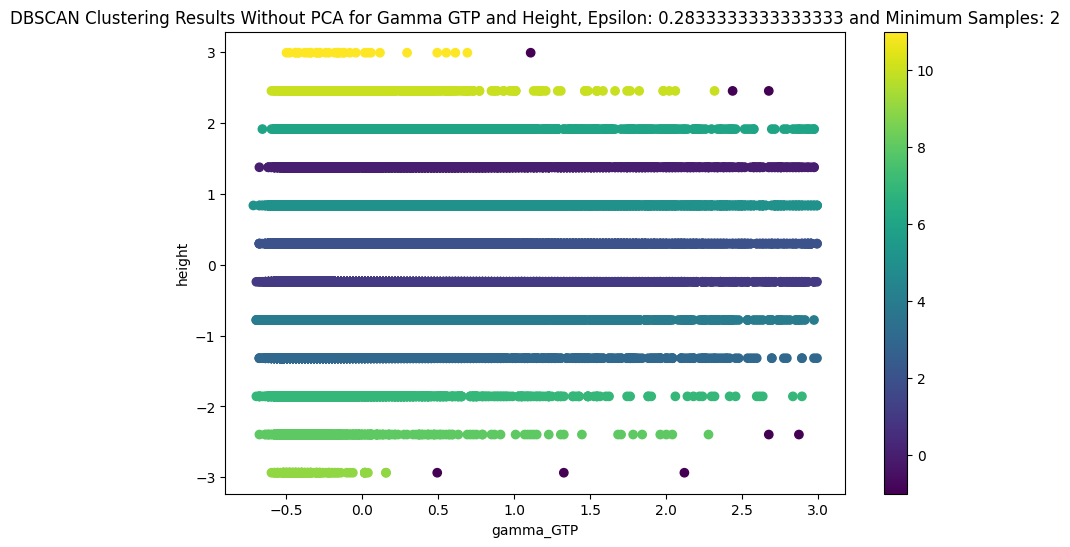

In [36]:
# Visualize the results
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X['gamma_GTP'], X['height'], c=X['cluster'], cmap='viridis')
plt.colorbar(scatter)
plt.title(f'DBSCAN Clustering Results Without PCA for Gamma GTP and Height, Epsilon: {best_dict_age["best_epsilon"]} and Minimum Samples: {best_dict_age["best_min_samples"]}')
plt.xlabel('gamma_GTP')
plt.ylabel('height')
plt.show()

In [39]:
labels = dbscan_height_gammgtp_w_optimal_parameters.labels_

silhouette_avg = silhouette_score(X, labels)
print("Silhouette Score:", silhouette_avg)

# Calculate Davies-Bouldin Index
db_index = davies_bouldin_score(X, labels)
print(f'Davies-Bouldin Index: {db_index:.4f}')

# Calculate Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f'Calinski-Harabasz Score: {ch_score:.4f}')

Silhouette Score: 0.7040230832662979
Davies-Bouldin Index: 0.6240
Calinski-Harabasz Score: 177866.0883
